# Preparing the data

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + ".,;"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines =open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split(".")[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

print(category_lines["French"][:5])

[u'data/names/Irish.txt', u'data/names/French.txt', u'data/names/Japanese.txt', u'data/names/German.txt', u'data/names/Vietnamese.txt', u'data/names/Dutch.txt', u'data/names/Polish.txt', u'data/names/Spanish.txt', u'data/names/Czech.txt', u'data/names/English.txt', u'data/names/Arabic.txt', u'data/names/Korean.txt', u'data/names/Greek.txt', u'data/names/Russian.txt', u'data/names/Chinese.txt', u'data/names/Portuguese.txt', u'data/names/Italian.txt', u'data/names/Scottish.txt']
Slusarski
[u'Abel', u'Abraham', u'Adam', u'Albert', u'Allard']


# Turning names into Tensors

In [3]:
import torch


In [5]:
# Find letter index from all_letters. e.g "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

#Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

#Turn a line into a <line_length x 1 x n_letters>
# of an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print( letterToTensor('J'))
print(lineToTensor("Jones"))



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 54 
    0     0     0
[torch.FloatTensor of size 1x55]


(0 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0

Columns 38 to 54 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

(1 ,.,.) = 

Columns 0 to 18 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0

Columns 19 to 37 
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Columns 38 to 54 
    0   0   0   0   0

# Creating the Network

In [82]:
np.nan

NameError: name 'np' is not defined

In [10]:
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [59]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        #combined = torch.cat((input, hidden), 1)
        output, hidden = self.lstm(input.view(len(input), 1, -1), hidden)
        output = self.lin(output.view(1, -1))

        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (Variable(torch.zeros(1, 1, self.hidden_size)),
                Variable(torch.zeros(1, 1, self.hidden_size)))

    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)


In [57]:
input = Variable(letterToTensor('A'))
hidden = rnn.initHidden()

output, next_hidden = rnn(input, hidden)

In [58]:
input = Variable(lineToTensor('Albert'))
hidden = rnn.initHidden()

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-2.9026 -2.8134 -2.9120 -2.8253 -2.8631 -2.8839 -2.9633 -2.9545 -2.9103 -2.9559

Columns 10 to 17 
-2.8942 -2.9315 -2.8224 -2.8455 -2.9240 -2.9691 -2.8651 -2.8144
[torch.FloatTensor of size 1x18]



# Training


## Preparing for training

In [60]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

(u'French', 1)


In [61]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category=', category, '/ line =', line)
    print(category_tensor)

category= Spanish / line = Crespo
Variable containing:
 7
[torch.LongTensor of size 1]

category= Dutch / line = Maes
Variable containing:
 5
[torch.LongTensor of size 1]

category= Irish / line = Bradach
Variable containing:
 0
[torch.LongTensor of size 1]

category= Polish / line = Bartosz
Variable containing:
 6
[torch.LongTensor of size 1]

category= German / line = Schultheis
Variable containing:
 3
[torch.LongTensor of size 1]

category= German / line = Scheinberg
Variable containing:
 3
[torch.LongTensor of size 1]

category= Vietnamese / line = Cao
Variable containing:
 4
[torch.LongTensor of size 1]

category= Dutch / line = Snijder
Variable containing:
 5
[torch.LongTensor of size 1]

category= Czech / line = Geier
Variable containing:
 8
[torch.LongTensor of size 1]

category= Portuguese / line = Cardozo
Variable containing:
 15
[torch.LongTensor of size 1]



## Training the network

In [62]:
criterion = nn.NLLLoss()

In [68]:
learning_rate = 0.01

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    #Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(- learning_rate, p.grad.data)
    
    return output, loss.data[0]

In [69]:
import time
import math

In [70]:
n_iters = 100000
print_every = 5000
plot_every = 1000

In [76]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print iter number, loss name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct =  '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (0m 59s) 1.6250 Matos / Greek ✗ (Portuguese)
10000 10% (1m 48s) 1.2426 Svoboda / Polish ✗ (Czech)
15000 15% (2m 38s) 3.4213 Ui / Chinese ✗ (Japanese)
20000 20% (3m 28s) 3.8663 Derjavets / Dutch ✗ (Russian)


KeyboardInterrupt: 

## Plotting the results

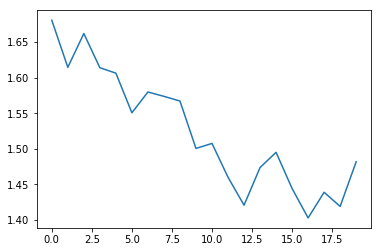

In [77]:
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker


plt.plot(all_losses)
plt.show()

## Evaluating the results

In [78]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

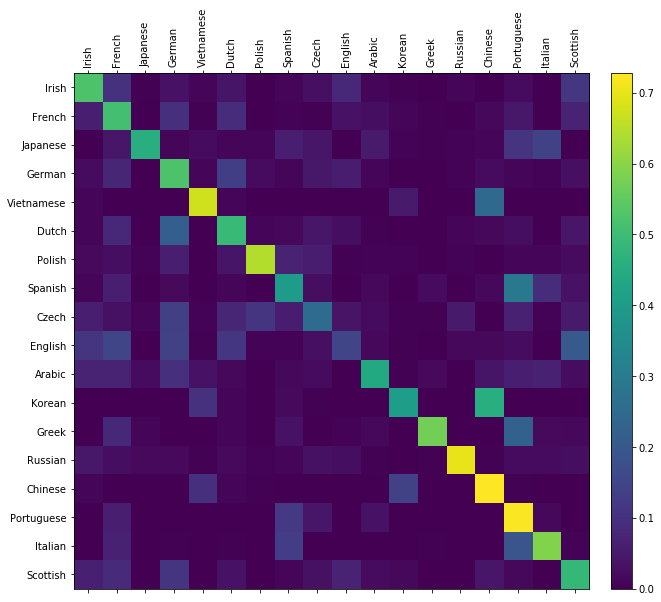

In [79]:
# Keep track of the correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output
    
# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Set up plot 
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)
im = ax.matshow(confusion.numpy())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "4%", pad = 0.3)
fig.colorbar(im, cax=cax)

# Set up axes 
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [1]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))
    
    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []
    
    for i in range(n_predictions):
        value = math.exp(topv[0][i])
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])
        
predict('Dovesky')
predict('Jackson')
predict('Satoshi')
    


> Dovesky


NameError: global name 'evaluate' is not defined

In [70]:
predict("Begotto")
predict("Leone")
predict("Piriou")
predict("Hollocoux")
predict("DaCosta")


> Begotto
(0.45) Italian
(0.14) Spanish
(0.12) Polish

> Leone
(0.32) French
(0.16) Irish
(0.14) Dutch

> Piriou
(0.42) French
(0.10) Spanish
(0.09) Greek

> Hollocoux
(0.41) French
(0.19) Portuguese
(0.10) Spanish

> DaCosta
(0.38) Spanish
(0.21) Italian
(0.21) Portuguese


In [75]:
predict("Chiche")
predict("Galland")


> Chiche
(0.56) Irish
(0.13) Portuguese
(0.10) Japanese

> Galland
(0.33) English
(0.19) Polish
(0.13) French


In [72]:
predict("Marcotte")
predict("Grinsztajn")
predict("Dupont")


> Marcotte
(0.22) Scottish
(0.19) Italian
(0.17) French

> Grinsztajn
(0.34) Russian
(0.25) German
(0.24) Dutch

> Dupont
(0.30) French
(0.14) Dutch
(0.12) English


In [74]:
predict("Berlusconi")


> Berlusconi
(0.76) Italian
(0.18) German
(0.02) French


In [76]:
predict('Rastapopoulos')


> Rastapopoulos
(0.97) Greek
(0.01) Polish
(0.01) Spanish
